In [1]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from scipy import stats

# Load data

Two datasets:
1. `sample_traces.pkl`: Voltage and spike times from simulated neurons.
2. `latency.csv`: Time to first spike for each cell, pre/post-pulse, replicate.

In [3]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_latency')

with open(os.path.join(DATA_PATH, 'sample_traces.pkl'), 'rb') as f:
    sample_traces = pickle.load(f)

latencies = pd.read_csv(os.path.join(DATA_PATH, 'latency.csv'))

## Inspect `sample_traces`

In [4]:
sample_traces.head()

,cell,model,post_amplitude,pre_amplitude,trace
0,DRN307,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,"{u'spks': [16.5], u't': [0.0, 0.1, 0.2, 0.3000..."
1,DRN307,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.05,"{u'spks': [], u't': [0.0, 0.1, 0.2, 0.30000000..."
2,DRN307,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,0.10,"{u'spks': [46.1, 113.5, 212.4, 348.90000000000..."
3,DRN307,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.02,-0.02,"{u'spks': [2570.2000000000003], u't': [0.0, 0...."
4,DRN307,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.02,-0.05,"{u'spks': [2181.7000000000003, 2962.5], u't': ..."


In [5]:
sample_traces.loc[0, 'trace']

{'V': array([-58.83875107, -58.86595215, -58.89312454, ..., -54.79079787,
        -54.79076709, -54.79073631]),
 'spks': array([16.5]),
 't': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 2.9997e+03, 2.9998e+03,
        2.9999e+03])}

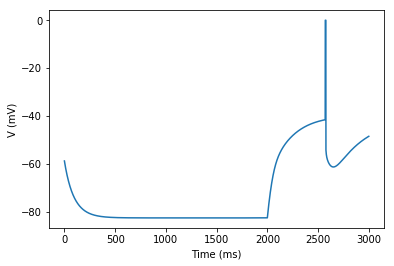

In [6]:
sample_trace_tmp = sample_traces.loc[3, 'trace']

plt.figure()
plt.subplot(111)
plt.plot(sample_trace_tmp['t'], sample_trace_tmp['V'])
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.show()

del sample_trace_tmp

Input is a hyperpolarizing pre-pulse followed by a depolarizing test-pulse.

## Inspect `latencies`

In [7]:
latencies.head()

,cell,latency,model,post_amplitude,pre_amplitude,premature_spike
0,DRN307,NaN,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,True
1,DRN307,NaN,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,False
2,DRN307,NaN,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,False
3,DRN307,NaN,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,False
4,DRN307,2347.5,<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02,False


Latency is the time of the first spike after the test pulse start (**TODO**: should be time *from* test pulse start). 

Latency can be `NaN` for two reasons:
1. There are no spikes before the end of the simulation.
2. There is at least one spike before the beginning of the test pulse.
    - If this happens, `premature_spike` is `True`.

In [8]:
print(
    'Pre-pulse amplitudes: {pre} \nPost-pulse amplitudes: {post}'.format(
        pre=latencies['pre_amplitude'].unique(), 
        post=latencies['post_amplitude'].unique()
    )
)

Pre-pulse amplitudes: [-0.02 -0.05  0.1 ] 
Post-pulse amplitudes: [0.01 0.02 0.03]


# Test whether IA model increases latency

In [9]:
grouping_factors = ('cell', 'model', 'pre_amplitude', 'post_amplitude')
grouped_data = {factor : [] for factor in grouping_factors}
grouped_data['latency'] = []
for grp in latencies.groupby(grouping_factors):
    for i, factor in enumerate(grouping_factors):
        grouped_data[factor].append(grp[0][i])
    grouped_data['latency'].append(grp[1]['latency'].tolist())
    
grouped_data = pd.DataFrame(grouped_data)
grouped_data.head()

,cell,latency,model,post_amplitude,pre_amplitude
0,DRN307,"[nan, 2284.9, nan, nan, nan, 2915.9, 2879.9, 2...",<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.05
1,DRN307,"[2181.7, 2629.1, 2494.9, 2388.3, 2371.7, 2357....",<class 'grr.AugmentedGIF.AugmentedGIF'>,0.02,-0.05
2,DRN307,"[2201.6, 2240.3, 2326.6, 2339.5, 2235.8, 2258....",<class 'grr.AugmentedGIF.AugmentedGIF'>,0.03,-0.05
3,DRN307,"[nan, nan, nan, nan, 2347.5, 2972.8, 2966.7, 2...",<class 'grr.AugmentedGIF.AugmentedGIF'>,0.01,-0.02
4,DRN307,"[2570.2, 2508.1, 2507.2, 2649.9, 2314.8, 2487....",<class 'grr.AugmentedGIF.AugmentedGIF'>,0.02,-0.02


In [10]:
def strip_nan(arr):
    return np.asarray(arr)[~np.isnan(arr)]

In [11]:
def get_sample_size(x):
    return sum(~np.isnan(x))

In [12]:
post_amps = grouped_data['post_amplitude'].unique()
num_trials = len(grouped_data['latency'][0])
minimum_spikes = float(num_trials) / 2.  # Do not test if sample size is less than this in each group.
p_crit_value = 0.05 / (len(post_amps) * len(latencies['cell'].unique()))  # Bonferroni corrected critical value.
print('Running U tests with Bonferroni-corrected significance threshold p = {:.5f}'.format(p_crit_value))

# TODO: get statistics for plotting.
statistics = {
    'cell' : [],
    'AugmentedGIF_latencies': [],
    'GIF_latencies': [],
    'significance': [],
    'AugmentedGIF_eligible_sweeps': [],
    'GIF_eligible_sweeps': [],
    'pre_amplitude': [],
    'post_amplitude': []
}

for post_amp in post_amps:
    lat_piv = grouped_data.loc[
        (grouped_data['post_amplitude'] == post_amp) 
        & (grouped_data['pre_amplitude'] == -0.02), 
        :
    ].pivot(index='cell', columns='model', values='latency')
    
    print('\n{:.3f}nA test pulse latencies'.format(post_amp))
    print('=' * 28)
    for i in range(len(lat_piv)):
        
        if (
            get_sample_size(lat_piv["<class 'grr.GIF.GIF'>"][i]) > minimum_spikes
            and 
            get_sample_size(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]) > minimum_spikes
        ):
            p_val = stats.mannwhitneyu(
                strip_nan(lat_piv["<class 'grr.GIF.GIF'>"][i]), 
                strip_nan(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]), 
                alternative='less'
            )[1]
            if p_val < p_crit_value:
                sig_str = '*'
            else:
                sig_str = ''

            print('{:>6} ({:>3}, {:>3}) p = {:.4f} {}'.format(
                lat_piv.index[i], 
                get_sample_size(lat_piv["<class 'grr.GIF.GIF'>"][i]),
                get_sample_size(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]), 
                p_val, 
                sig_str
            ))
        else:
            print('{:>6} ({:>3}, {:>3}) Skipped'.format(
                lat_piv.index[i],
                get_sample_size(lat_piv["<class 'grr.GIF.GIF'>"][i]),
                get_sample_size(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i])
            ))

Running U tests with Bonferroni-corrected significance threshold p = 0.00093

0.010nA test pulse latencies
DRN307 (280, 268) p = 0.0270 
DRN308 (  4,   1) Skipped
DRN317 (  3,   0) Skipped
DRN318 ( 19,   2) Skipped
DRN319 (233, 201) Skipped
DRN320 (  3,   1) Skipped
DRN321 (381, 452) p = 0.0001 *
DRN324 (306, 273) p = 0.0195 
DRN325 (267, 270) p = 0.0046 
DRN327 ( 65,  17) Skipped
DRN332 (121,  98) Skipped
DRN384 (  4,   4) Skipped
DRN385 (118,  65) Skipped
DRN386 (265,  73) Skipped
   JF3 ( 29,   6) Skipped
   JF5 (  1,   0) Skipped
   JF6 ( 80,  15) Skipped
   JF7 (419, 486) p = 0.0000 *

0.020nA test pulse latencies
DRN307 (466, 490) p = 0.8297 
DRN308 ( 31,   2) Skipped
DRN317 ( 20,   0) Skipped
DRN318 (101,  62) Skipped
DRN319 (246, 201) Skipped
DRN320 ( 19,   4) Skipped
DRN321 (392, 449) p = 0.0024 
DRN324 (492, 496) p = 0.0000 *
DRN325 (408, 480) p = 0.2254 
DRN327 (322, 482) p = 0.3260 
DRN332 (357, 483) p = 0.0009 *
DRN384 ( 49,  61) Skipped
DRN385 (373, 350) p = 0.1353 
DRN38

Cell ID (left), number of trials with spikes for `(GIF, AugmentedGIF)` out of 500, p-value for **one-sided** U-test that AugmentedGIF increases latency. Star indicates significance after Bonferroni correction. U-test is skipped if not enough trials have non-`NaN` latencies (see above for reasons why some latencies are `NaN`).

**Conclusion:** Incorporating IA into the model increases spike latency in some cells under some conditions. 

Could imply:
- change in latency is sometimes small/hard to detect
- real effect of IA on *voltage dependence* of latency isn't captured by this analysis
    - better analysis would be some kind of non-parametric two way ANOVA with pre-pulse amplitude and model as factors (is this possible?)
- GIF can compensate somewhat for missing IA with other parameters
- fitting algorithm underestimates IA so much that functional effect is often obscured

# Latency plots
Focus on simulations with -20pA pre-pulse and 20pA test pulse.

In [13]:
lat_piv = grouped_data.loc[
    (grouped_data['post_amplitude'] == 0.02) 
    & (grouped_data['pre_amplitude'] == -0.02), 
    :
].pivot(index='cell', columns='model', values='latency')

lat_piv.head()

model,<class 'grr.AugmentedGIF.AugmentedGIF'>,<class 'grr.GIF.GIF'>
cell,,
DRN307,"[2570.2, 2508.1, 2507.2, 2649.9, 2314.8, 2487....","[2495.8, 2638.5, 2303.4, 2882.7, 2129.1, 2353...."
DRN308,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
DRN317,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, 2562.3, nan, nan, nan, nan, na..."
DRN318,"[nan, nan, nan, nan, 2790.2, 2487.9, nan, 2343...","[nan, nan, nan, nan, nan, 2533.2, nan, nan, na..."
DRN319,"[nan, 2198.2, nan, nan, nan, nan, 2056.0, nan,...","[nan, 2124.0, nan, nan, nan, 2058.9, 2090.3, n..."


In [14]:
def hist_contrast_plot(models, ax=None, bins='auto', **pltargs):
    if ax is None:
        ax = plt.gca()
    
    for mod in models:
        ax.hist(models[mod], bins=bins, density=True, histtype='step', label=mod, **pltargs)
    
    ax.legend()

def cumulative_distribution(x):
    x_sorted = np.sort(x)
    cumulative_proba = np.linspace(1./len(x_sorted), 1., len(x_sorted))
    return x_sorted, cumulative_proba

def cumulative_distribution_pct_reduction(model_base, model_alt):
    """Percent difference in cumulative distributions."""
    base_x, base_y = cumulative_distribution(model_base)
    alt_x, alt_y = cumulative_distribution(model_alt)
    union_x = np.sort(np.union1d(base_x, alt_x))

    base_interpolated_y = np.interp(union_x, base_x, base_y, left=0.)
    alt_interpolated_y = np.interp(union_x, alt_x, alt_y, left=0.)

    pct_change = (alt_interpolated_y - base_interpolated_y) / base_interpolated_y

    return union_x, pct_change  

def cumulative_distribution_plot(models, ax=None, omit_label=False, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    color_cycle = ('r', 'k')
    for i, mod in enumerate(models):
        x, y = cumulative_distribution(models[mod])
        if not omit_label:
            ax.plot(x, y, label=mod, color=color_cycle[i%len(color_cycle)], **pltargs)
        else:
            ax.plot(x, y, color=color_cycle[i%len(color_cycle)], **pltargs)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


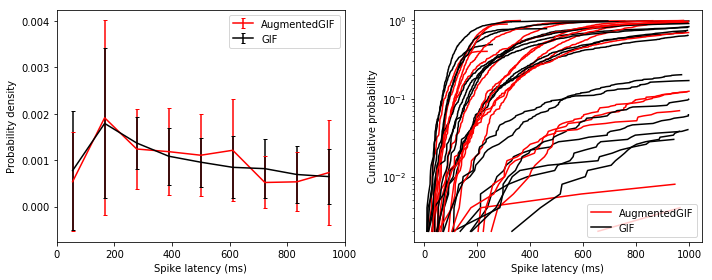

In [15]:
step_start_time = 2000.
bins = np.linspace(0., 1000., 10)

spec = gs.GridSpec(1, 2)

plt.figure(figsize=(10, 4))

plt.subplot(spec[0, 0])
hist_vals = {
    'AugmentedGIF': [],
    'GIF': []
}
hist_edges = np.linspace(0., 1000., 10)
for i in range(len(lat_piv)):
    hist_vals_tmp, _ = np.histogram(
        strip_nan(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]) - step_start_time, 
        bins=hist_edges,
        density=True
    )
    hist_vals['AugmentedGIF'].append(hist_vals_tmp)
    hist_vals_tmp, _ = np.histogram(
        strip_nan(lat_piv["<class 'grr.GIF.GIF'>"][i]) - step_start_time, 
        bins=hist_edges,
        density=True
    )
    hist_vals['GIF'].append(hist_vals_tmp)
    
    del hist_vals_tmp
    
hist_vals = {key: np.array(hist_vals[key]) for key in hist_vals}

plt.errorbar(
    x=(hist_edges[:-1] + hist_edges[1:])/2., 
    y=np.nanmean(hist_vals['AugmentedGIF'], axis=0), 
    yerr=np.nanstd(hist_vals['AugmentedGIF'], axis=0),
    color='r',
    ecolor='r',
    capsize=2.,
    label='AugmentedGIF'
)
plt.errorbar(
    x=(hist_edges[:-1] + hist_edges[1:])/2., 
    y=np.nanmean(hist_vals['GIF'], axis=0), 
    yerr=np.nanstd(hist_vals['GIF'], axis=0),
    color='k',
    ecolor='k',
    capsize=2.,
    label='GIF'
)
plt.xlim(0, 1000.)
plt.xlabel('Spike latency (ms)')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(spec[0, 1])
for i in range(len(lat_piv)):
    try:
        if i == 0:
            cumulative_distribution_plot(
                {
                    'AugmentedGIF': np.asarray(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]) - step_start_time,
                    'GIF': np.asarray(lat_piv["<class 'grr.GIF.GIF'>"][i]) - step_start_time
                }
            )
        else:
            cumulative_distribution_plot(
                {
                    'AugmentedGIF': np.asarray(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]) - step_start_time,
                    'GIF': np.asarray(lat_piv["<class 'grr.GIF.GIF'>"][i]) - step_start_time
                },
                omit_label=True
            )

    except ValueError:
        continue
plt.gca().set_yscale('log')
plt.xlabel('Spike latency (ms)')
plt.ylabel('Cumulative probability')
plt.legend()

plt.tight_layout()
plt.show()

Average normalized histogram (left) and cumulative distribution of spike latencies for each cell (right). (Not all cumulative distributions to go 1 because of `NaN` latencies; see above for reasons `NaN`s are introduced.)

Pretty hard to see how IA is affecting latency this way.

# Individual latency histograms

One plot with both models for each cell. Vertical lines indicate median latency for each model. Test pulse starts at 2000ms.

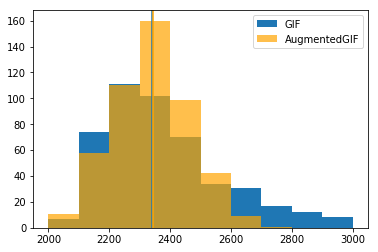

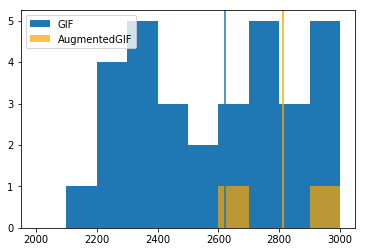

/miniconda3/envs/neopozz/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


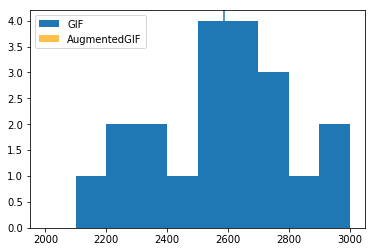

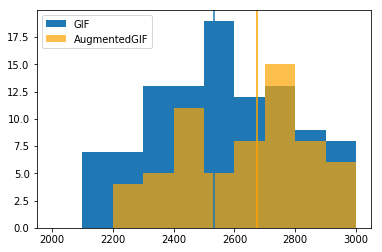

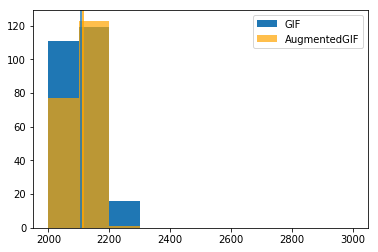

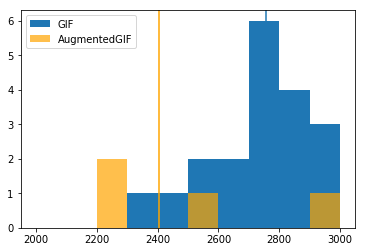

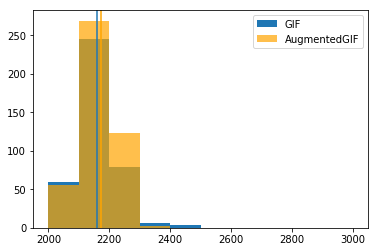

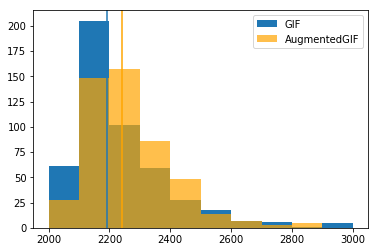

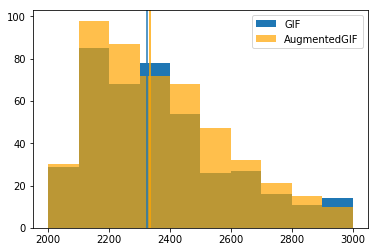

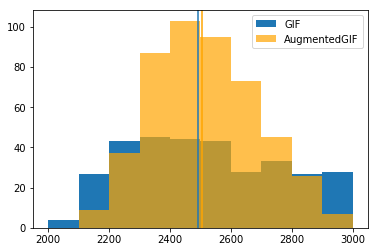

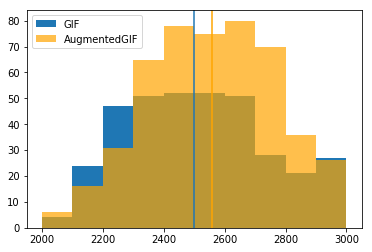

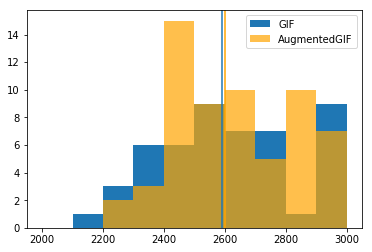

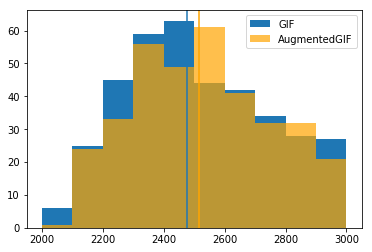

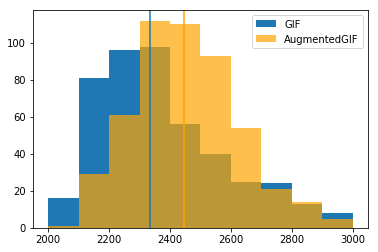

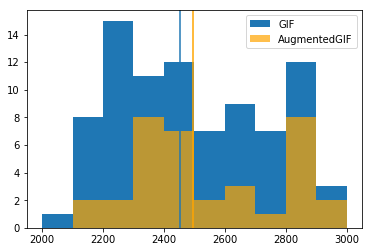

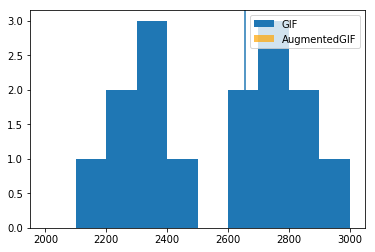

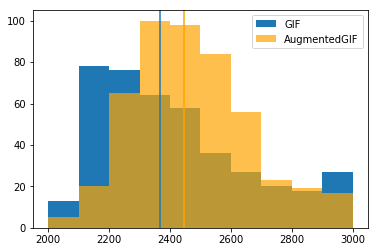

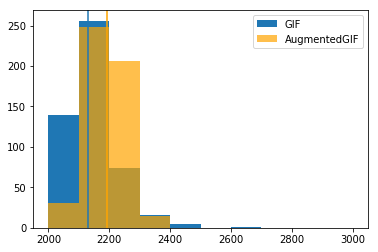

In [16]:
for i in range(len(lat_piv)):
    plt.figure()
    
    plt.hist(
        np.asarray(lat_piv["<class 'grr.GIF.GIF'>"][i])[~np.isnan(lat_piv["<class 'grr.GIF.GIF'>"][i])],
        range=(2000, 3000),
        label='GIF'
    )
    plt.axvline(np.nanmedian(lat_piv["<class 'grr.GIF.GIF'>"][i]))
    plt.hist(
        np.asarray(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i])[~np.isnan(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i])], 
        range=(2000, 3000),
        alpha=0.7,
        color='orange',
        label='AugmentedGIF'
    )
    plt.axvline(np.nanmedian(lat_piv["<class 'grr.AugmentedGIF.AugmentedGIF'>"][i]), color='orange')
    plt.legend()
    
    plt.show()

The median latency of the AugmentedGIF (orange vertical line) seems consistenly longer than that of the GIF (blue vertical line).